In [69]:
import warnings
from typing import Any
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc

from utils import plot_roc
import ml_utils as utils
from ml_utils import get_weights_for_roc_auc, weighted_roc_metric, get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# aft, magn > 3.5

## read 

In [2]:
dataset_type_train = "magn_3_5_aft_train"
dataset_type_test = "magn_3_5_aft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [3]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_3_5_aft_train.parquet
test_path: data/dataset/magn_3_5_aft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-08-26
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1593709, target==1: 27847
test: target==0: 6428932, target==1: 98518
target class proportion: test: 0.015324162706962836, train: 0.01747307695445028


In [4]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [5]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [6]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [7]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [8]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [9]:
roc_auc_weights_test

array([0.08894231, 0.08894231, 0.08894231, ..., 0.00240385, 0.00240385,
       0.00240385])

In [10]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(6527450,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

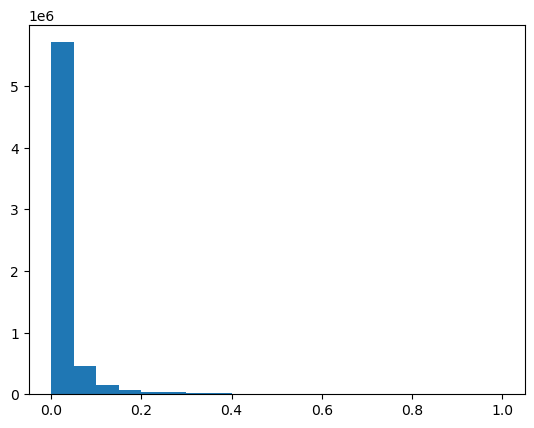

In [11]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [12]:
y_train = y_train[target]
y_test = y_test[target]

In [13]:
y_train.sum(), y_test.sum()

(27847, 98518)

## lgbm

In [14]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [15]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-21, 2015-10-22], len: 405389 | test: [2015-11-01, 2017-06-23], len: 419131
train: [2014-03-21, 2017-06-23], len: 824520 | test: [2017-07-03, 2019-02-23], len: 419131
train: [2014-03-21, 2019-02-23], len: 1243651 | test: [2019-03-05, 2020-08-26], len: 377905


### baseline

In [16]:
params = {
    "n_estimators": 30,
    "objective": "binary",
    "use_missing": False,
    "deterministic": True,
    "random_state": 42,
    "force_col_wise": True,
    "feature_pre_filter": False,
    "verbosity": -1,
    "max_depth": 2,
    "n_jobs": 50,
}

lgbm_model = train.get_lgbm_model(feature_cols, params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, y_pred_prob[:, 1])
)

(0.7474579527978402,
 0.7245491514554685,
 '----',
 0.7971908551315507,
 0.8233852914992372)

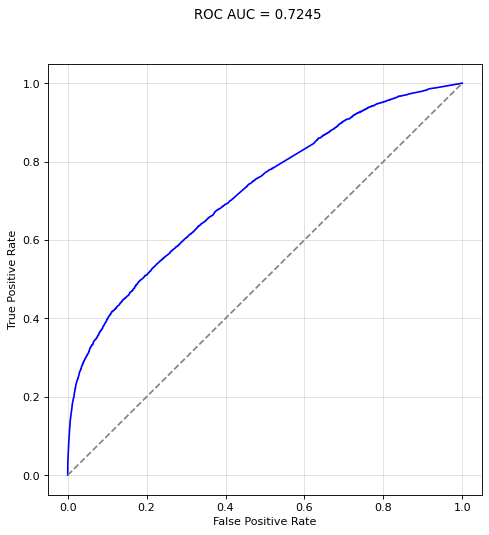

In [19]:
plot_roc(y_test, y_pred_prob[:, 1]);

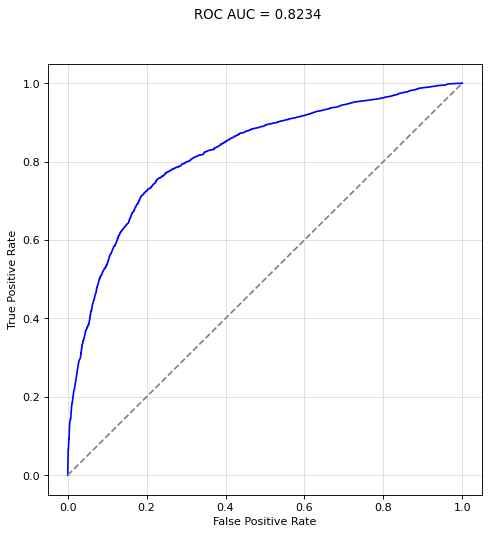

In [17]:
plot_roc(y_test, y_pred_prob[:, 1], roc_auc_weights_test);

In [20]:
len(np.unique(y_pred_prob[:, 1]))

34076

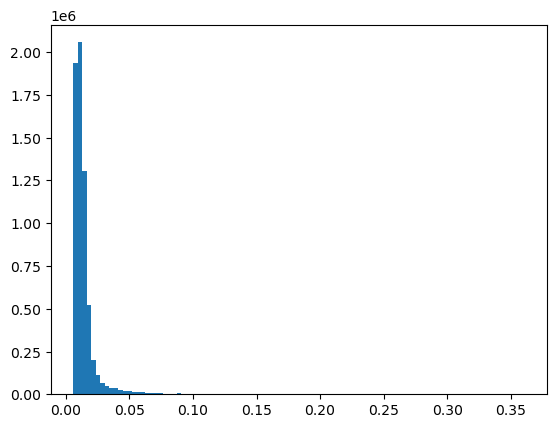

In [22]:
plt.hist(y_pred_prob[:, 1], bins=100);

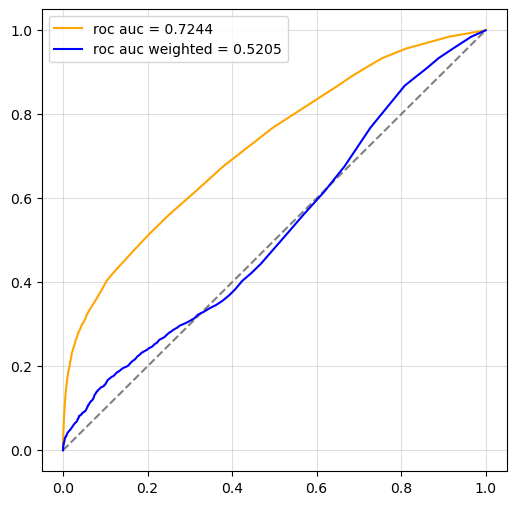

In [24]:
plot_roc_curves(y_test, y_pred_prob[:, 1], roc_auc_weights_test, n=1_000)

### shap feature selection

In [25]:
from sklearn.metrics import make_scorer
from probatus.utils import Scorer


weighted_roc_auc_sklearn_scorer = make_scorer(weighted_roc_metric, greater_is_better=True)
weighted_roc_auc_probatus_scorer = Scorer("weighted_roc_auc", custom_scorer=weighted_roc_auc_sklearn_scorer)

shap_params = params.copy()
shap_params["n_jobs"] = 5

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lgbm_reg = lgb.LGBMRegressor(**shap_params)

imputer = SimpleImputer(
    strategy="constant",
    fill_value=0.0,
).set_output(transform="pandas")
X_train_preprocessed = imputer.fit_transform(X_train)

shap_elimination, lgbm_shap_features = train.select_features(
    model=lgbm_reg,
    X=X_train_preprocessed,
    y=y_train,
    cv=cv,
    n_jobs=20,
    metric=weighted_roc_auc_probatus_scorer,
    step=0.05,
    return_rfe=True,
)

 98%|===================| 412400/419131 [00:52<00:00]        2024-12-21 13:24:36.924 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 132, Current performance: Train 0.8037965975483926 +/- 0.003307100799930858, CV Validation 0.7867644711390581 +/- 0.00732183213087902. 
Features left: ['day_of_month_sin', 'min_magn_3650_rad0', 'count_earthquakes_3650_rad3', 'min_magn_180_rad5', 'std_magn_2555_rad5', 'dt_month', 'mean_magn_3650_rad0', 'mean_magn_365_rad0', 'max_magn_1825_rad3', 'count_earthquakes_180_rad3', 'mean_magn_1095_rad3', 'std_magn_1825_rad5', 'max_magn_60_rad3', 'mean_magn_1825_rad0', 'max_magn_1095_rad0', 'max_magn_2555_rad3', 'std_magn_2555_rad3', 'mean_magn_2555_rad5', 'std_magn_1825_rad0', 'mean_magn_60_rad5', 'min_magn_2555_rad0', 'min_magn_1095_rad3', 'day_of_year', 'std_magn_90_rad3', 'mean_magn_180_rad0', 'min_magn_60_rad3', 'std_magn_60_rad3', 'std_magn_1095_rad5', 'min_magn_1825_rad5', 'std_magn_90_rad0', 'co

In [26]:
lgbm_shap_features

['day_of_month_sin',
 'min_magn_3650_rad0',
 'count_earthquakes_3650_rad3',
 'min_magn_180_rad5',
 'std_magn_2555_rad5',
 'dt_month',
 'mean_magn_3650_rad0',
 'mean_magn_365_rad0',
 'max_magn_1825_rad3',
 'count_earthquakes_180_rad3',
 'mean_magn_1095_rad3',
 'std_magn_1825_rad5',
 'max_magn_60_rad3',
 'mean_magn_1825_rad0',
 'max_magn_1095_rad0',
 'max_magn_2555_rad3',
 'std_magn_2555_rad3',
 'mean_magn_2555_rad5',
 'std_magn_1825_rad0',
 'mean_magn_60_rad5',
 'min_magn_2555_rad0',
 'min_magn_1095_rad3',
 'day_of_year',
 'std_magn_90_rad3',
 'mean_magn_180_rad0',
 'min_magn_60_rad3',
 'std_magn_60_rad3',
 'std_magn_1095_rad5',
 'min_magn_1825_rad5',
 'std_magn_90_rad0',
 'count_earthquakes_1825_rad3',
 'std_magn_1095_rad0',
 'std_magn_90_rad5',
 'dt_year',
 'mean_magn_1825_rad5',
 'count_earthquakes_60_rad0',
 'count_earthquakes_365_rad0',
 'count_earthquakes_90_rad0',
 'max_magn_3650_rad0',
 'cell_x',
 'std_magn_2555_rad0',
 'min_magn_3650_rad3',
 'max_magn_180_rad5',
 'min_magn_365_

In [27]:
print(len(lgbm_shap_features))
utils.get_features_dict(lgbm_shap_features)

132


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [28]:
lgbm_model = train.get_lgbm_model(lgbm_shap_features, shap_params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, lgbm_model.predict_proba(X_test)[:, 1])
)

(0.7474579527978402,
 0.7245491514554685,
 '----',
 0.7971908551315507,
 0.8233852914992372)

### hyper optimiziation

In [29]:
import optuna
import optuna.trial
import optuna.logging

optuna.logging.set_verbosity(optuna.logging.WARNING)


def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "objective": "binary",
        "use_missing": False,
        "deterministic": True,
        "random_state": 42,
        "force_col_wise": True,
        "feature_pre_filter": False,
        "verbosity": -1,
        "n_jobs": 1,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "colsample_bytree": 1.0,
        "subsample": 1.0,
        "learning_rate": 0.01,
        "num_leaves": 31,
        "min_child_samples": 20,
        "n_estimators": 10,
        "max_depth": 2,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "n_estimators": trial.suggest_int("n_estimators", 3, 200, step=1),
        "max_depth": trial.suggest_int("max_depth", 1, 5, step=1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001),
        "num_leaves": trial.suggest_int("num_leaves", 5, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 15.0, step=0.1),
    }
    params.update(kwargs)

    return params

tuned_lgbm = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 500,
    dump_study_path = f"data/optuna_res/lgbm_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_lgbm_model(lgbm_shap_features, default_params()),
    n_jobs = 50,
    model_name = "lgbmclassifier",
)

using MonthlyTimeSeriesSplit


lgbmclassifier hyperoptimisation:  67%|██████▋   | 334/500 [4:23:48<2:35:41, 56.28s/it]/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
lgbmclassifier hyperoptimisation:  71%|███████   | 355/500 [4:40:09<1:57:28, 48.61s/it]/home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
lgbmclassifier hyperoptimisation:  94%|█████████▍| 470/500 [6:12:27<22:17, 44.59s/it]  /home/prc/anaconda3/envs/smartdevds10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. T

In [30]:
tuned_lgbm_params = tuned_lgbm["lgbmclassifier"].get_params()
tuned_lgbm_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.25537310435375754,
 'importance_type': 'split',
 'learning_rate': 0.035,
 'max_depth': 5,
 'min_child_samples': 13,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 151,
 'n_jobs': 1,
 'num_leaves': 33,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 2.4000000000000004,
 'silent': 'warn',
 'subsample': 0.9998242403458382,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'use_missing': False,
 'deterministic': True,
 'force_col_wise': True,
 'feature_pre_filter': False,
 'verbosity': -1}

In [65]:
# reulst_aft_lgbm = tuned_lgbm.fit(X_train, y_train)
y_pred_prob = reulst_aft_lgbm.predict_proba(X_test)

(
    roc_auc_score(y_train, reulst_aft_lgbm.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, reulst_aft_lgbm.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, y_pred_prob[:, 1])
)

(0.6822165784822948,
 0.6543101511792845,
 '----',
 0.6119205893525674,
 0.6631985435901006)

In [66]:
len(np.unique(y_pred_prob[:, 1]))

311374

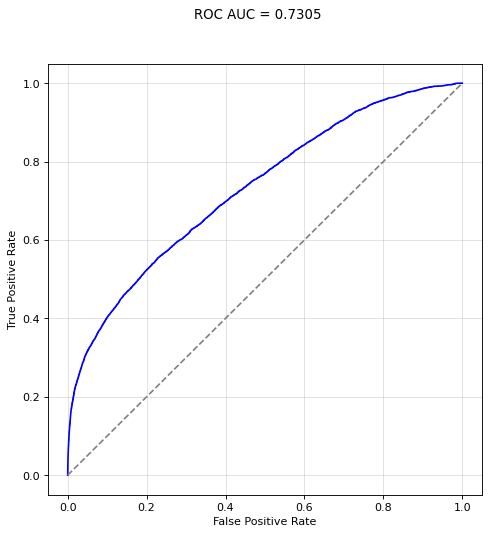

In [32]:
plot_roc(target=y_test, prediction=y_pred_prob[:, 1], weights=None);

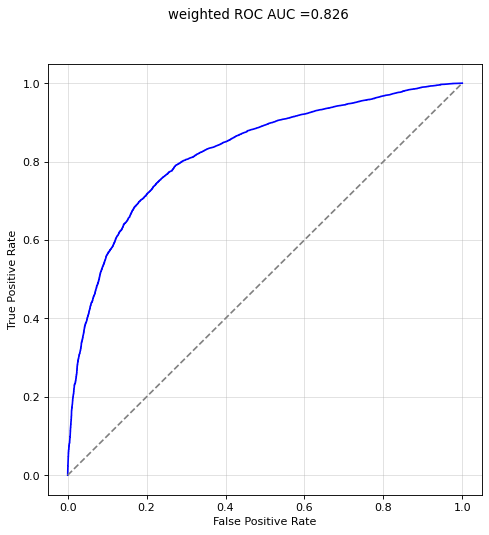

In [33]:
plot_roc(target=y_test, prediction=y_pred_prob[:, 1], weights=roc_auc_weights_test, src_label="weighted");

In [35]:
t = get_optimal_trs(y_train.astype(int), reulst_aft_lgbm.predict_proba(X_train)[:, 1], sample_weight=None)
print("optimal trs:", t)

binary_preds = y_pred_prob[:, 1].copy()
binary_preds[y_pred_prob[:, 1] >= t] = 1
binary_preds[y_pred_prob[:, 1] < t]
precision_recall_fscore_support(y_test.astype(int), binary_preds.astype(int))

optimal trs: [0.014868269847156949]


(array([0.99133754, 0.03322878]),
 array([0.74306246, 0.57629063]),
 array([0.84943002, 0.06283454]),
 array([6428932,   98518]))

In [36]:
t = get_optimal_trs(y_train.astype(int), reulst_aft_lgbm.predict_proba(X_train)[:, 1], sample_weight=None)
print("optimal trs:", t)

binary_preds = y_pred_prob[:, 1].copy()
binary_preds[y_pred_prob[:, 1] >= t] = 1
binary_preds[y_pred_prob[:, 1] < t]
precision_recall_fscore_support(y_test.astype(int), binary_preds.astype(int), sample_weight=roc_auc_weights_test)

optimal trs: [0.014868269847156949]


(array([0.98722246, 0.09486893]),
 array([0.44720483, 0.90917426]),
 array([0.61556366, 0.17181012]),
 array([164482.31010762,  10482.11298077]))

In [72]:
# with open("data/models/aft_3_5_lgbm.pickle", "xb") as f:
joblib.dump(reulst_aft_lgbm, "data/models/aft_3_5_lgbm.pickle")

['data/models/aft_3_5_lgbm.pickle']

# withoutaft, magn > 3.5

## read 

In [38]:
dataset_type_train = "magn_3_5_withoutaft_train"
dataset_type_test = "magn_3_5_withoutaft_test"

target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

train_path = f"data/dataset/{dataset_type_train}.parquet"
test_path = f"data/dataset/{dataset_type_test}.parquet"

In [39]:
train_df, test_df = utils.get_train_test_datasets(
    train_path=train_path, test_path=test_path, 
    min_test_date = min_test_date, min_train_date = min_train_date
)

train_path: data/dataset/magn_3_5_withoutaft_train.parquet
test_path: data/dataset/magn_3_5_withoutaft_test.parquet

get_features_dict:
 {0: [0, 1, 3, 5, 7, 10]
3: [0, 1, 3, 5, 7, 10]
5: [0, 1, 3, 5, 7, 10]}

train dates: 2014-03-21 — 2020-10-05
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1129198, target==1: 8402
test: target==0: 4461907, target==1: 41093
target class proportion: test: 0.009209739243780742, train: 0.007440679136874136


In [40]:
feature_cols = list(set(train_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))

In [41]:
# train, test
features = utils.Features(
    features=feature_cols, target=target, dt_col=dt_col, 
    groupby=["cell_x", "cell_y"], target_features=[]
)

X_train, y_train = features.make_features_target(train_df)
X_test, y_test = features.make_features_target(test_df)

In [42]:
y_test.reset_index().merge(y_train.reset_index(), how="left").isna().sum()

dt        0
cell_x    0
cell_y    0
target    0
dtype: int64

In [43]:
# get weights for roc auc as probability density of occured earthquakes
roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date)
roc_auc_weights_train = get_weights_for_roc_auc(y=y_train, last_dt=min_test_date)

In [44]:
assert len(roc_auc_weights_test) == len(roc_auc_weights_test[~np.isnan(roc_auc_weights_test)]) == len(y_test)
assert len(roc_auc_weights_train) == len(roc_auc_weights_train[~np.isnan(roc_auc_weights_train)]) == len(y_train)

In [45]:
len(roc_auc_weights_test[roc_auc_weights_test > 0.0]), np.max(roc_auc_weights_test), np.unique(roc_auc_weights_test)

(4503000,
 1.0,
 array([0.00240385, 0.00480769, 0.00721154, 0.00961538, 0.01201923,
        0.01442308, 0.01682692, 0.01923077, 0.02163462, 0.02403846,
        0.02644231, 0.02884615, 0.03125   , 0.03365385, 0.03605769,
        0.03846154, 0.04086538, 0.04326923, 0.04567308, 0.04807692,
        0.05048077, 0.05288462, 0.05528846, 0.05769231, 0.06009615,
        0.0625    , 0.06490385, 0.06730769, 0.06971154, 0.07211538,
        0.07451923, 0.07692308, 0.07932692, 0.08173077, 0.08413462,
        0.08653846, 0.08894231, 0.09134615, 0.09375   , 0.09615385,
        0.09855769, 0.10096154, 0.10336538, 0.10576923, 0.10817308,
        0.11057692, 0.11298077, 0.11538462, 0.11778846, 0.12019231,
        0.12259615, 0.125     , 0.12740385, 0.12980769, 0.13221154,
        0.13461538, 0.13701923, 0.13942308, 0.14182692, 0.14423077,
        0.14663462, 0.14903846, 0.15144231, 0.15384615, 0.15625   ,
        0.15865385, 0.16105769, 0.16346154, 0.16586538, 0.16826923,
        0.17067308, 0.17307692, 

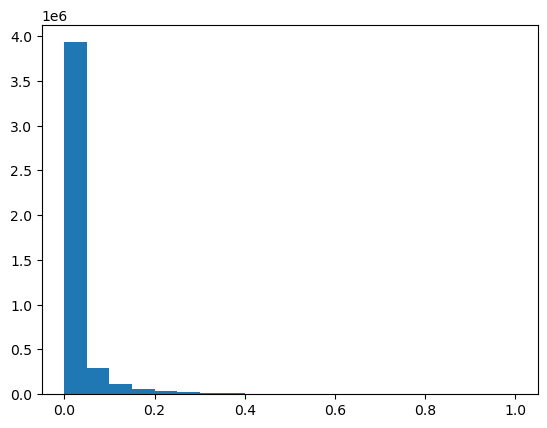

In [46]:
plt.hist(roc_auc_weights_test[roc_auc_weights_test > 0.0], range=(0, 1.0), bins=20);

In [47]:
y_train = y_train[target]
y_test = y_test[target]

In [48]:
y_train.sum(), y_test.sum()

(8402, 41093)

## lgbm

In [49]:
cv = utils.MonthlyTimeSeriesSplit(window=20)
cv.get_n_splits(X_train)

3

In [50]:
for split_train, split_test in cv.split(X_train):
    train_start = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    train_end = np.sort(X_train.iloc[split_train].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]
    test_start = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[0]
    test_end = np.sort(X_train.iloc[split_test].drop(columns=["cell_x", "cell_y"]).reset_index()["dt"].unique())[-1]

    print(f"train: [{train_start}, {train_end}], len: {len(split_train)} | test: [{test_start}, {test_end}], len: {len(split_test)}")

train: [2014-03-21, 2015-10-22], len: 279660 | test: [2015-11-01, 2017-06-23], len: 289140
train: [2014-03-21, 2017-06-23], len: 568800 | test: [2017-07-03, 2019-02-23], len: 289140
train: [2014-03-21, 2019-02-23], len: 857940 | test: [2019-03-05, 2020-10-05], len: 279660


### baseline

In [51]:
params = {
    "n_estimators": 5,
    "objective": "binary",
    "use_missing": False,
    "deterministic": True,
    "random_state": 42,
    "force_col_wise": True,
    "feature_pre_filter": False,
    "verbosity": -1,
    "max_depth": 2,
    "n_jobs": 50,
}

lgbm_model = train.get_lgbm_model(feature_cols, params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

baseline_roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, lgbm_model.predict_proba(X_test)[:, 1])
)

(0.7162732273900797,
 0.6543508418422476,
 '----',
 0.6611049351806,
 0.6541230978613672)

### shap feature selection

In [52]:
shap_params = params.copy()
shap_params["n_jobs"] = 5

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lgbm_reg = lgb.LGBMRegressor(**shap_params)

imputer = SimpleImputer(
    strategy="constant",
    fill_value=0.0,
).set_output(transform="pandas")
X_train_preprocessed = imputer.fit_transform(X_train)

shap_elimination, lgbm_shap_features = train.select_features(
    model=lgbm_reg,
    X=X_train_preprocessed,
    y=y_train,
    # min_features_to_select=30,
    cv=cv,
    n_jobs=20,
    metric=weighted_roc_auc_probatus_scorer,
    step=0.05,
    return_rfe=True,
)

feature selection:   0%|          | 0/66 [00:00<?, ?it/s]2024-12-21 21:31:44.681 | INFO     | probatus.feature_elimination.feature_elimination:fit:519 - Round: 1, Current number of features: 132, Current performance: Train 0.6830831021428966 +/- 0.009224685745983686, CV Validation 0.6662154883605206 +/- 0.01089224068452541. 
Features left: ['day_of_month_sin', 'min_magn_3650_rad0', 'count_earthquakes_3650_rad3', 'min_magn_180_rad5', 'std_magn_2555_rad5', 'dt_month', 'mean_magn_3650_rad0', 'mean_magn_365_rad0', 'max_magn_1825_rad3', 'count_earthquakes_180_rad3', 'mean_magn_1095_rad3', 'std_magn_1825_rad5', 'max_magn_60_rad3', 'mean_magn_1825_rad0', 'max_magn_1095_rad0', 'max_magn_2555_rad3', 'mean_magn_2555_rad5', 'std_magn_2555_rad3', 'std_magn_1825_rad0', 'mean_magn_60_rad5', 'min_magn_2555_rad0', 'min_magn_1095_rad3', 'day_of_year', 'std_magn_90_rad3', 'mean_magn_180_rad0', 'min_magn_60_rad3', 'std_magn_60_rad3', 'std_magn_1095_rad5', 'min_magn_1825_rad5', 'std_magn_90_rad0', 'count_

In [53]:
lgbm_shap_features

['min_magn_3650_rad0',
 'min_magn_180_rad5',
 'dt_month',
 'count_earthquakes_180_rad3',
 'std_magn_90_rad5',
 'cell_x',
 'min_magn_365_rad5',
 'cell_y',
 'mean_magn_90_rad5',
 'count_earthquakes_60_rad3',
 'count_earthquakes_90_rad5',
 'count_earthquakes_180_rad5',
 'count_earthquakes_365_rad3']

In [54]:
print(len(lgbm_shap_features))
utils.get_features_dict(lgbm_shap_features)

13


{0: [10], 3: [0, 1], 5: [0, 1]}

In [55]:
lgbm_model = train.get_lgbm_model(lgbm_shap_features, shap_params)

lgbm_model = lgbm_model.fit(X_train, y_train)
y_pred_prob = lgbm_model.predict_proba(X_test)

(
    roc_auc_score(y_train, lgbm_model.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, lgbm_model.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, lgbm_model.predict_proba(X_test)[:, 1])
)

(0.7152609447931105,
 0.653043847081682,
 '----',
 0.6612955510262554,
 0.6448194676674203)

### hyper optimiziation

In [56]:
import optuna
import optuna.trial
import optuna.logging

optuna.logging.set_verbosity(optuna.logging.WARNING)


def fixed_params(**kwargs) -> dict[str, Any]:
    params = {
        "objective": "binary",
        "use_missing": False,
        "deterministic": True,
        "random_state": 42,
        "force_col_wise": True,
        "feature_pre_filter": False,
        "verbosity": -1,
        "n_jobs": 1,
    }

    params.update(kwargs)

    return params


def default_params(**kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "colsample_bytree": 1.0,
        "subsample": 1.0,
        "learning_rate": 0.01,
        "num_leaves": 31,
        "min_child_samples": 20,
        "n_estimators": 10,
        "max_depth": 2,
    }
    params.update(kwargs)

    return params


def suggest_params(trial: optuna.trial.Trial, **kwargs) -> dict[str, Any]:
    params = {
        **fixed_params(),
        "n_estimators": trial.suggest_int("n_estimators", 3, 200, step=1),
        "max_depth": trial.suggest_int("max_depth", 1, 5, step=1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001),
        "num_leaves": trial.suggest_int("num_leaves", 5, 50),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 15.0, step=0.1),
    }
    params.update(kwargs)

    return params

tuned_lgbm = train.run_optuna(
    X = X_train,
    y = y_train,
    n_trials = 500,
    dump_study_path = f"data/optuna_res/lgbm_{dataset_type_train.replace('_train', '')}",
    seed = 42,
    resume = False,
    suggest_params = suggest_params,
    default_params = default_params,
    cv = utils.MonthlyTimeSeriesSplit(window=20, partition=True),
    model = train.get_lgbm_model(lgbm_shap_features, default_params()),
    n_jobs = 50,
    model_name = "lgbmclassifier",
)

using MonthlyTimeSeriesSplit


lgbmclassifier hyperoptimisation: 100%|██████████| 500/500 [1:35:11<00:00, 11.42s/it]


In [57]:
tuned_lgbm_params = tuned_lgbm["lgbmclassifier"].get_params()
tuned_lgbm_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.25248893942473033,
 'importance_type': 'split',
 'learning_rate': 0.036000000000000004,
 'max_depth': 3,
 'min_child_samples': 48,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 133,
 'n_jobs': 1,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.1,
 'silent': 'warn',
 'subsample': 0.44744458434402773,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'use_missing': False,
 'deterministic': True,
 'force_col_wise': True,
 'feature_pre_filter': False,
 'verbosity': -1}

In [58]:
reulst_witoutaft_lgbm = tuned_lgbm.fit(X_train, y_train)
y_pred_prob = reulst_witoutaft_lgbm.predict_proba(X_test)

(
    roc_auc_score(y_train, reulst_witoutaft_lgbm.predict_proba(X_train)[:, 1]), 
    roc_auc_score(y_test, y_pred_prob[:, 1]),
    "----",
    weighted_roc_metric(y_train, reulst_witoutaft_lgbm.predict_proba(X_train)[:, 1]),
    weighted_roc_metric(y_test, reulst_witoutaft_lgbm.predict_proba(X_test)[:, 1])
)

(0.74129426882835,
 0.6603405730295001,
 '----',
 0.7149139144053744,
 0.6767286031529318)

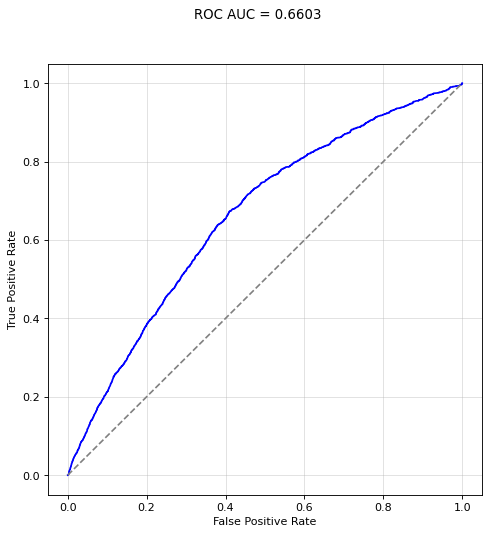

In [59]:
plot_roc(target=y_test, prediction=y_pred_prob[:, 1], weights=None);

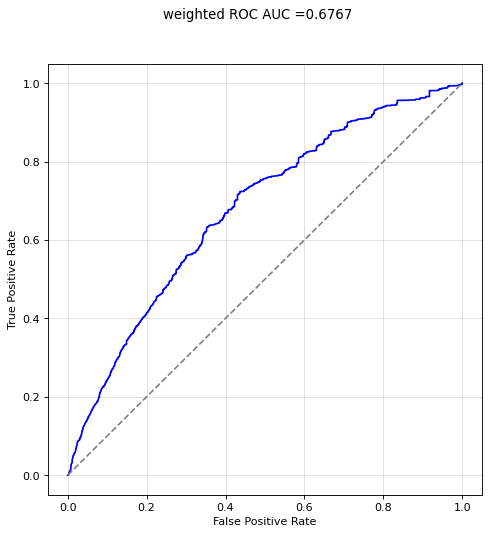

In [60]:
plot_roc(target=y_test, prediction=y_pred_prob[:, 1], weights=roc_auc_weights_test, src_label="weighted");

In [61]:
t = get_optimal_trs(y_train.astype(int), reulst_witoutaft_lgbm.predict_proba(X_train)[:, 1], sample_weight=None)
print("optimal trs:", t)

binary_preds = y_pred_prob[:, 1].copy()
binary_preds[y_pred_prob[:, 1] >= t] = 1
binary_preds[y_pred_prob[:, 1] < t]
precision_recall_fscore_support(y_test.astype(int), binary_preds.astype(int))

optimal trs: [0.008380552460648354]


(array([0.99491337, 0.01478719]),
 array([0.58600459, 0.67468912]),
 array([0.73757629, 0.02894009]),
 array([4461907,   41093]))

In [62]:
t = get_optimal_trs(y_train.astype(int), reulst_witoutaft_lgbm.predict_proba(X_train)[:, 1], sample_weight=None)
print("optimal trs:", t)

binary_preds = y_pred_prob[:, 1].copy()
binary_preds[y_pred_prob[:, 1] >= t] = 1
binary_preds[y_pred_prob[:, 1] < t]
precision_recall_fscore_support(y_test.astype(int), binary_preds.astype(int), sample_weight=roc_auc_weights_test)

optimal trs: [0.008380552460648354]


(array([0.99404318, 0.01709262]),
 array([0.69389356, 0.56143539]),
 array([0.81728201, 0.03317524]),
 array([125563.69711835,   1190.50961538]))

In [73]:
with open("data/models/withoutaft_3_5_lgbm.pickle", "xb") as f:
    joblib.dump(reulst_witoutaft_lgbm, f)